Both the code and the report for HW1 can be found in this Jupyter Notebook.  
Please note: to replicate the code for geopandas, you will need to work in python 3.4 environment, as geopandas is not compatible with python 3.5 yet.

In [173]:
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import geopandas as gpd #to load geopandas, the conda environment has to be set to python 3.4
import requests
import numpy as np 
%matplotlib inline  

sns.set_context("notebook", font_scale=1)
sns.set_style("ticks")

# Problem 1: Data Acquisition and Analysis

In [174]:
#import data 
communityareas = gpd.read_file("shapefiles/communityareas.shp")
graffiti = pd.read_csv("data/graffiti.csv")
graffiti.columns = graffiti.columns.str.title() #set column names to title
potholes = pd.read_csv("data/potholes.csv")
potholes.columns = potholes.columns.str.title() #set column names to title
vacant = pd.read_csv("data/vacant.csv")
vacant.columns = vacant.columns.str.title() #set column names to title
sanitation = pd.read_csv("data/sanitation.csv")
sanitation.columns = sanitation.columns.str.title() #set column names to title

In [175]:
def time_trend(df, y, col, label, count = True):
    #plots time trends of data by month    
    if count == True: #count the number of occurrences per month
        
        #manipulates column to become datetime format 
        df[col] = pd.to_datetime(df[col])
        df['Month'] = df[col].dt.month
        a = df.groupby('Month').count()
        a = a.reset_index()
        ax = sns.pointplot(x = "Month", y = y, data = a)
        ax.set(ylabel= label)
    
    else: #averages the values by month
        df[col] = pd.to_datetime(df[col])
        df['Month'] = df[col].dt.month
        a = df.groupby('Month').mean()
        a = a.reset_index()
        ax = sns.pointplot(x = "Month", y = y, data = a)
        ax.set(ylabel= label)
        
    return ax 

In [176]:
def merge_spatial(df, gdf):
    #combines spatial (map of chicago community areas) and non-spatial dataframe (311 Service Requests)
    area_count = df.groupby('Community Area').count()[[1]]
    area_count = area_count.reset_index()
    area_count.columns = ['area_numbe', 'Count']
    area_count['area_numbe'] = area_count['area_numbe'].astype(int)
    
    gdf['area_numbe'] = gdf['area_numbe'].astype(int)
    merged = gdf.merge(area_count, on = 'area_numbe')
    
    return merged 

In [177]:
def neighborhood_map(df, gdf):
    #plot quintile map of community areas 
    merged = merge_spatial(df, gdf)
    ax = merged.plot(column = "Count", cmap = "YlGnBu", scheme = "QUANTILES", k = 5, legend = True, figsize = (12, 8))
    
    return ax

In [178]:
def response(df):
    #creates response time variable in df 
    creation = pd.to_datetime(df['Creation Date'])
    complete = pd.to_datetime(df['Completion Date'])
    diff = complete - creation 

    df['Response Time'] = (pd.to_timedelta(diff,unit='d')+pd.to_timedelta(1,unit='s')).astype('timedelta64[D]')
    
    return df

## Graffiti Removal Service Requests

There are 116795 graffiti removal service requests for the past year. According to the line graph of graffiti removal requests by month, there appears to be lesser graffiti removal requests in Winter from December to March. Despite the smaller number service requests posted in colder months in Chicago, the response time by the city does not appear to have a time trend. 

In [179]:
graffiti_no = len(graffiti.index)
graffiti_no

116795

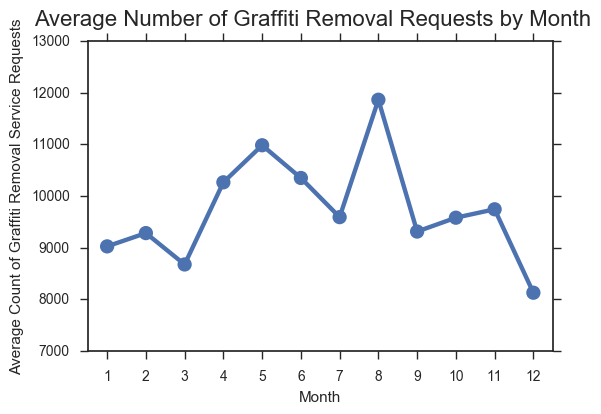

In [180]:
time_trend(graffiti, "Status", 'Creation Date', 'Average Count of Graffiti Removal Service Requests')
plt.suptitle("Average Number of Graffiti Removal Requests by Month", fontsize = 16)

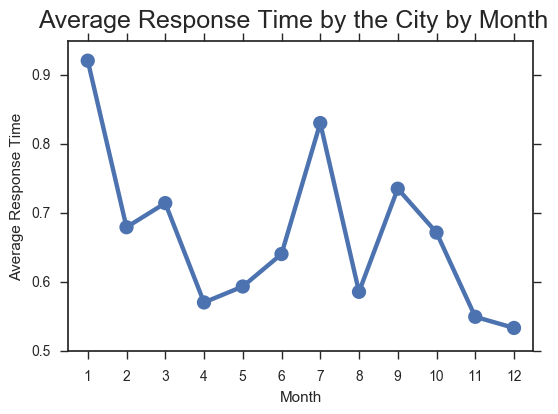

In [181]:
time_trend(response(graffiti), 'Response Time', 'Creation Date', 'Average Response Time', count = False)
plt.suptitle("Average Response Time by the City by Month", fontsize = 18)

The quintile map of graffiti removal service requests per community area shows that Northern and Western regions of Chicago have a higher number graffiti removal service requests, whereas the community areas of the Southern regions mostly belong to the bottom two quintiles. 

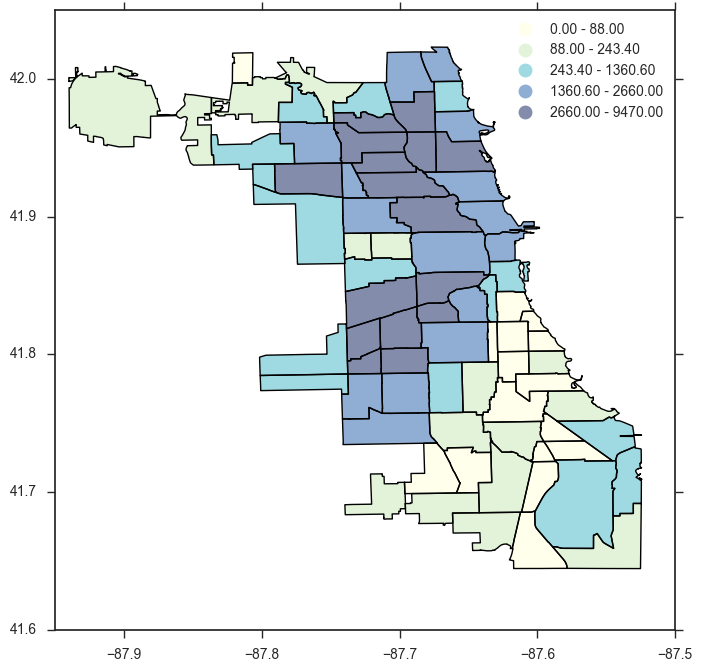

In [182]:
neighborhood_map(graffiti, communityareas)

Most of the graffiti were on brick and painted metal surfaces, which is unsurprising, as these are the most common materials used in public places. 

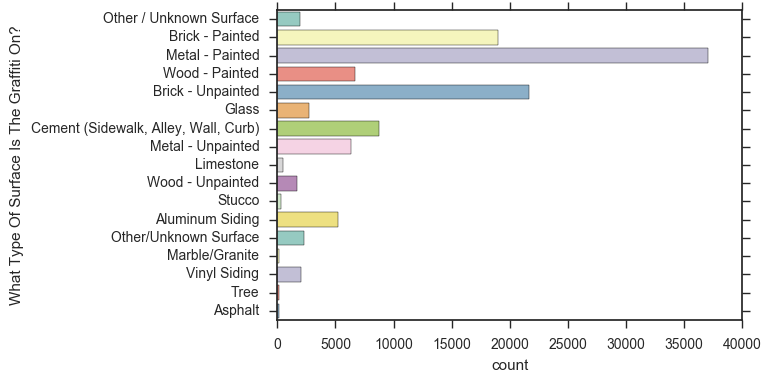

In [188]:
ax = sns.countplot(y="What Type Of Surface Is The Graffiti On?", data=graffiti, palette="Set3")

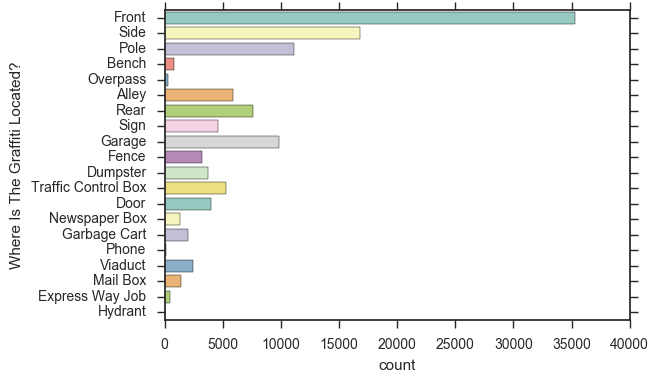

In [189]:
ax = sns.countplot(y="Where Is The Graffiti Located?", data=graffiti, palette="Set3")

## Potholes

There are 55726 potholes service requests for the past year. According to the line graph of potholes by month, there appears to be a decline from January to December. However, our data is from a period of April 2016 to April 2017. Instead of a strict decline from January to December, the line graph actually shows a sudden spike in reported potholes in January 2017 from December 2016. According to the line graph of reponse time by the city regarding pothole service requests, response times are longer from May to September. 

In [190]:
len(potholes.index)

55726

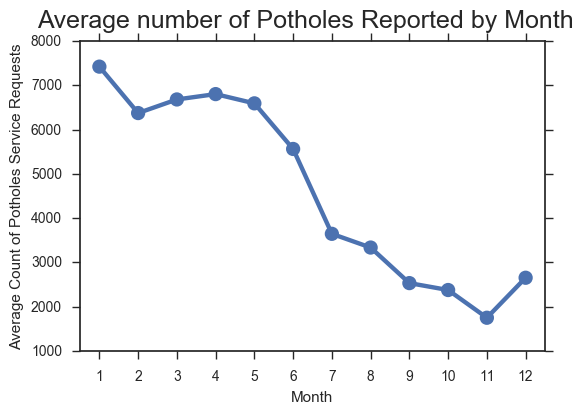

In [191]:
time_trend(potholes, "Status", 'Creation Date', 'Average Count of Potholes Service Requests')
plt.suptitle("Average number of Potholes Reported by Month", fontsize = 18)

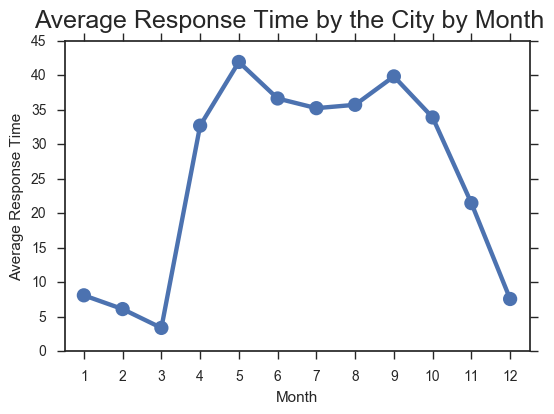

In [192]:
time_trend(response(potholes), 'Response Time', 'Creation Date', 'Average Response Time', count = False)
plt.suptitle("Average Response Time by the City by Month", fontsize = 18)

The quintile map of reported potholes by community areas show that potholes are least reported in the Loop and areas closer to downtown. This could suggest that better quality roads are paved in the city than the suburbs and outskirts. 

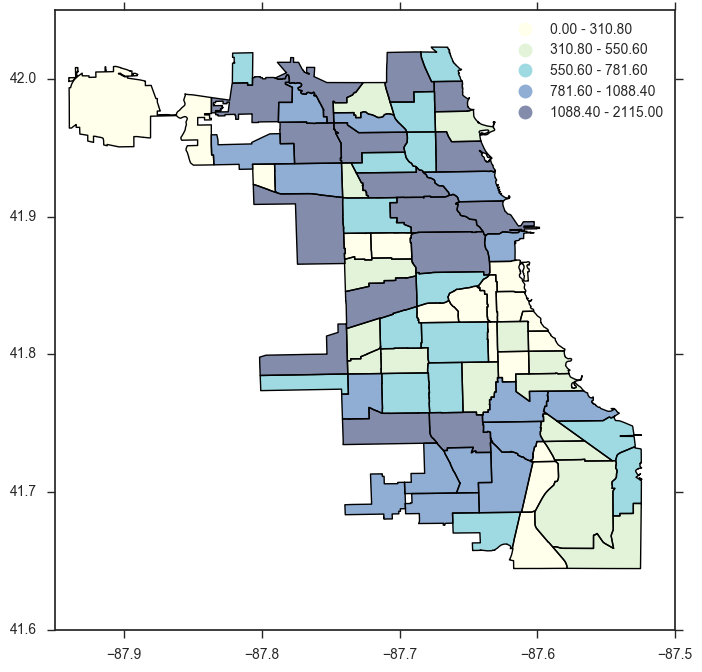

In [193]:
neighborhood_map(potholes, communityareas)

## Vacant and Abandoned Buildings

There are 4718 vacant and abandoned buildings reported for the past year. Similar to graffiti removal service requests, there appears to be more vacant buildings reported in warmer months, such as May to August, and lesser buildings reported in colder months, from October to January.

In [195]:
len(vacant.index)

4718

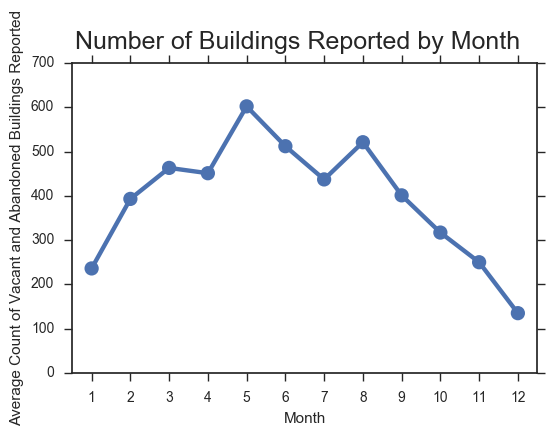

In [196]:
time_trend(vacant, "Service Request Number", 'Date Service Request Was Received', 'Average Count of Vacant and Abandoned Buildings Reported')
plt.suptitle("Number of Buildings Reported by Month", fontsize = 18)

Most of the vacant buildings are located at the front of the lot, followed by the rear, and a minority are in the garage. 

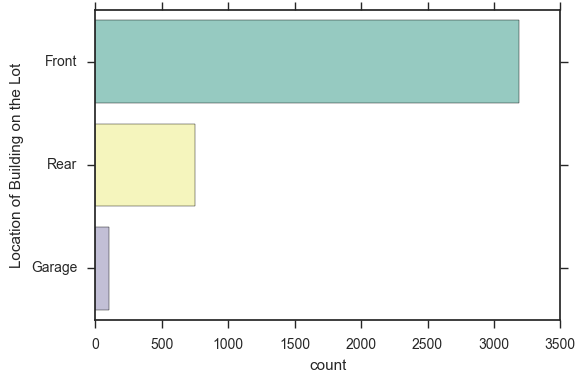

In [197]:
ax = sns.countplot(y="Location Of Building On The Lot (If Garage, Change Type Code To Bgd).", data=vacant, palette="Set3")
plt.ylabel("Location of Building on the Lot")

According to the quintile map, the Northern community areas have the least reported number of vacant and abandoned buildings and the Southern community areas have the highest number of vacant and abandoned buildings reported. 

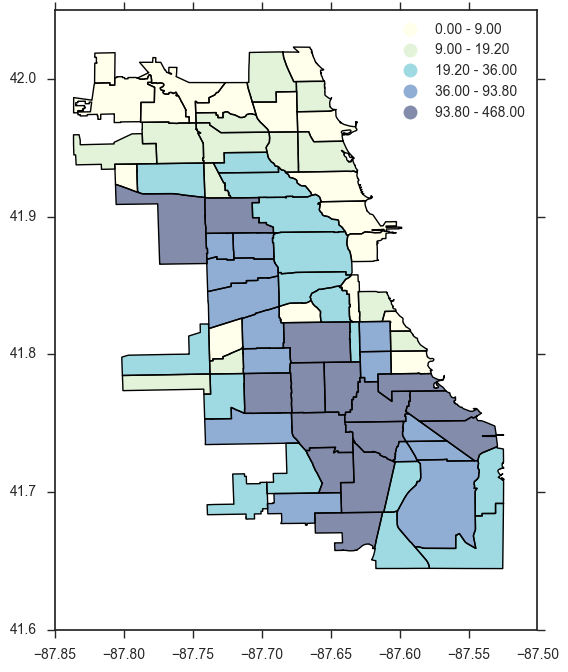

In [198]:
neighborhood_map(vacant, communityareas)

## Sanitation Code Violations Service Requests

There are 21423 number of sanitation code violation service requests for the past year. Similar to graffiti removal service requests and reports on vacant and abandoned buildings, there appears to be more sanitation code violations reported in warmer months and less sanitation code violations reported in colder months. Since there is a greater number of reports of sanitation code violations, the response time of the city also increases in warmer months from June to August. 

In [200]:
len(sanitation.index)

21423

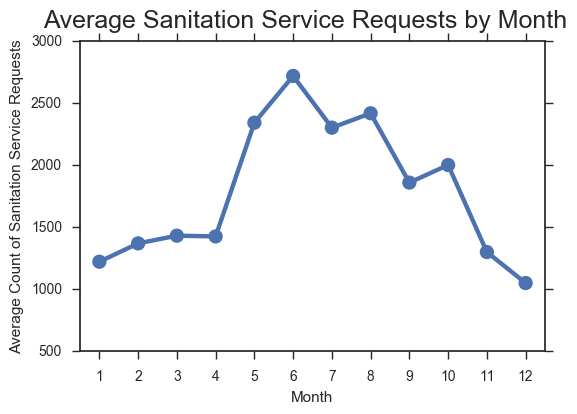

In [201]:
ax = time_trend(sanitation, "Status", 'Creation Date', 'Average Count of Sanitation Service Requests')
plt.suptitle("Average Sanitation Service Requests by Month", fontsize = 18)


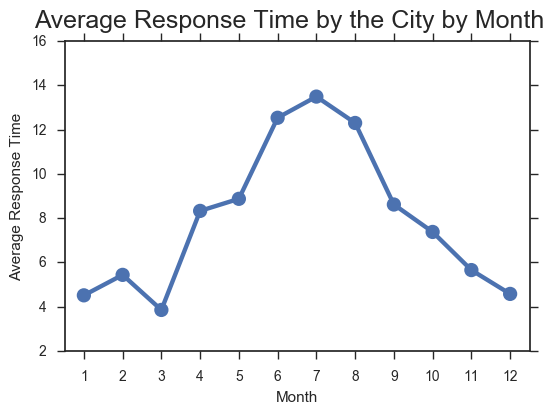

In [202]:
time_trend(response(sanitation), 'Response Time', 'Creation Date', 'Average Response Time', count = False)
plt.suptitle("Average Response Time by the City by Month", fontsize = 18)

A substantial number of the sanitation code violations are related to garbage, such as garbage in alley and yard, and dumpster not being emptied. 

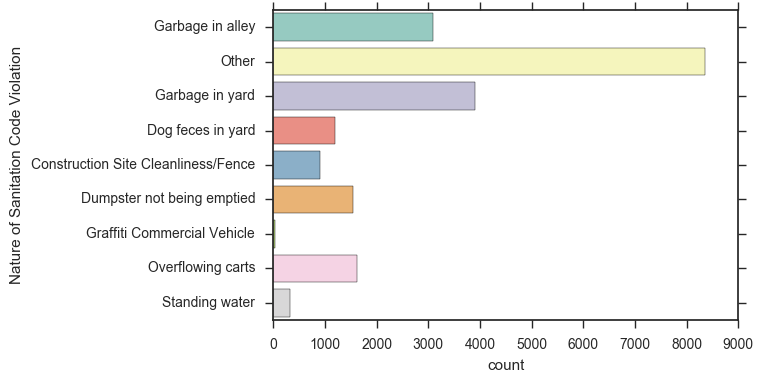

In [208]:
ax = sns.countplot(y="What Is The Nature Of This Code Violation?", data=sanitation, palette="Set3")
plt.ylabel("Nature of Sanitation Code Violation")

Similar to reported potholes, the quintile map shows that sanitation code violations are least reported in the Loop and areas closer to downtown. This could suggest that these community areas receive better cleanliness services than than the suburbs and outskirts. 

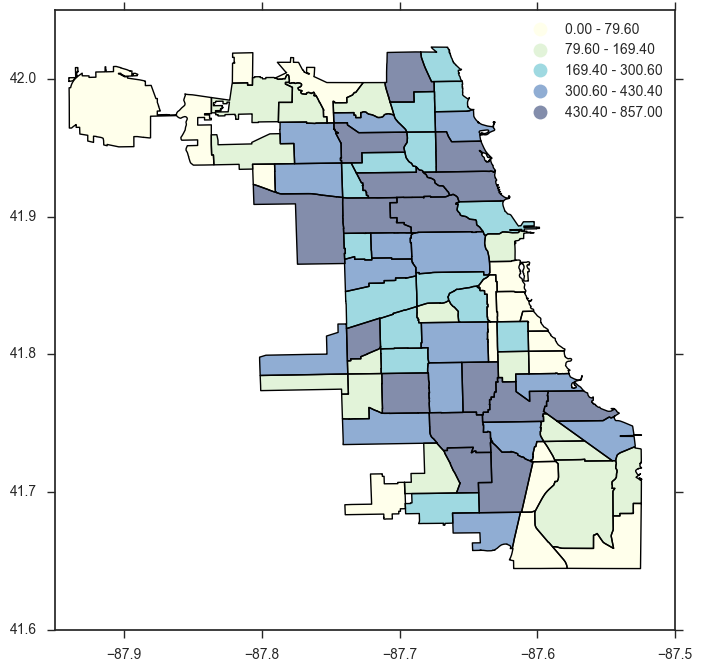

In [205]:
neighborhood_map(sanitation, communityareas)

## Five Interesting Things 

1. The Loop and community areas close to the Loop receive better quality services. 
2. The City is more reactive to sanitation code violation reports than graffiti removal reports. 
3. There is significantly less graffiti removal service requets in the Southern community areas of Chicago than Northern community areas. 
4. There are, in general, lesser service requests during wintry months from November to March. 
5. There is significantly more vacant and abandoned buildings in the Southern community areas of Chicago than the rest of Chicago.

# Problem 2: Data Augmentation and APIs

To supplement the 311 data, I used an API to download education, income, family size and unmarried pregnancies data on the ZIP code level from the American Community Survey. I measured education with the proportion of the population above 25 years old with a Bachelor's degree, income with the median worker annual income, and family size as the average family size of families in the ZIP code. 

In [42]:
zipcodes = np.arange(60001, 63000, 1) #possible IL zip codes
zipcodes = list(map(str, zipcodes)) #convert to strings

i = 1
for i in range(1, len(zipcodes)):
    try:
        #to download data from all the illinois zip codes 
        addr = "http://api.census.gov/data/2015/acs5/"
        addr += "profile?get=DP02_0037PE,DP02_0064PE,DP02_0016E,DP03_0092E,NAME&for=zip+code+tabulation+area:"
        # DP02_0037PE Unmarried Women 15 to 50 years old who had a birth in the past 12 months
        # DP02_0064PE Educational Attainment; Population>25 years old with a Bachelor's Degree 
        # DP02_0016E Average Family Size 
        # DP03_0092E Median Worker Income
        addr += zipcodes[i] #concat the strings at the back
        addr += "&key=0ce2733a4fa90e2ba156a55f538706c3338d1674"
        j = requests.get(addr).json()

        if i == 1:
            df = pd.DataFrame(j[1:], columns = j[0])
        else: 
            df1 = pd.DataFrame(j[1:], columns = j[0])
            df = df.append(df1) #final dataset
        
    except:
        continue #to not terminate for zip codes that are not found in ACS
    i += 1

In [134]:
df.columns = ['fertility', 'education', 'familysize', 'income', 'Name', 'Zip Code']
df['Zip Code'] = df['Zip Code'].astype(int)
vacant = vacant[np.isfinite(vacant['Zip Code'])]
vacant['Zip Code'] = vacant['Zip Code'].astype(int)

In [69]:
vacant_demo = vacant.merge(df, on = 'Zip Code')
vacant_demo['income'] = vacant_demo['income'].astype(int)
vacant_demo['fertility'] = vacant_demo['fertility'].astype(float)
vacant_demo['education'] = vacant_demo['education'].astype(float)
vacant_demo['familysize'] = vacant_demo['familysize'].astype(float)

vacant_demographics = vacant_demo.groupby('Zip Code').mean()[[-4,-3,-2, -1]]
vacant_demographics = vacant_demographics.reset_index()
#create count of vacant buildings per zip code
count = count.reset_index()
count.columns = ['Zip Code', 'Count']
#merge count data and demographics data 
count = count.merge(vacant_demographics, on = "Zip Code")

## Vacant and Abandoned Buildings Demographics

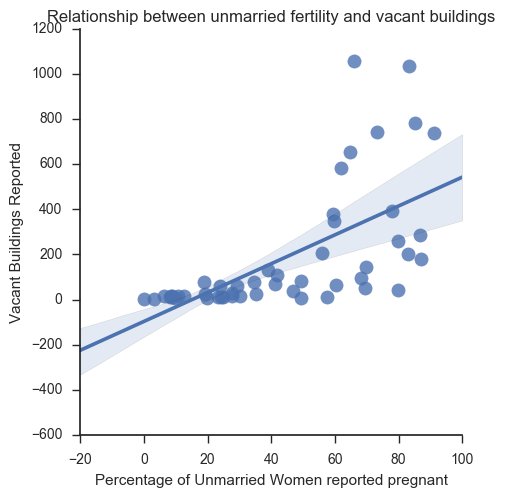

In [128]:
sns.lmplot('fertility', 'Count',
           data=count,
           fit_reg=True,
           scatter_kws={"marker": "D",
                        "s": 100})
plt.title('Relationship between unmarried fertility and vacant buildings')
plt.xlabel('Percentage of Unmarried Women reported pregnant')
plt.ylabel('Vacant Buildings Reported')


The higher the number of vacant and abandoned buildings in the ZIP code, the higher the proportion of unmarried women pregnancy. 

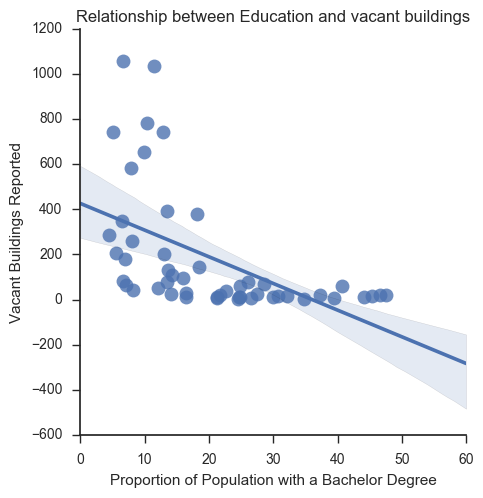

In [132]:
sns.lmplot('education', 'Count',
           data=count,
           fit_reg=True,
           scatter_kws={"marker": "D",
                        "s": 100})
plt.title('Relationship between Education and vacant buildings')
plt.xlabel('Proportion of Population with a Bachelor Degree')
plt.ylabel('Vacant Buildings Reported')

The higher the number of vacant and abandoned buildings in the ZIP code, the lower the proportion of population having attained a Bachelor's degree. 

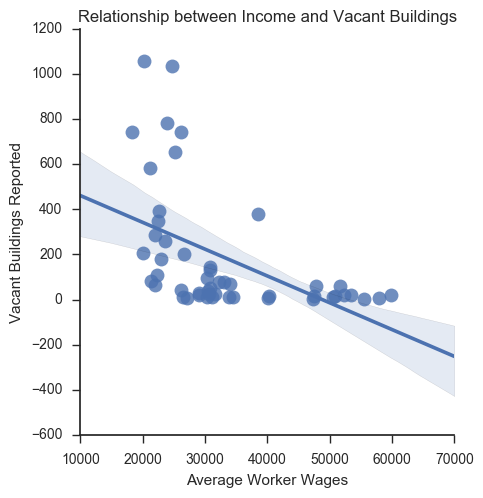

In [133]:
sns.lmplot('income', 'Count',
           data=count,
           fit_reg=True,
           scatter_kws={"marker": "D",
                        "s": 100})
plt.title('Relationship between Income and Vacant Buildings')
plt.xlabel('Average Worker Wages')
plt.ylabel('Vacant Buildings Reported')

The higher the number of vacant and abandoned buildings in the ZIP code, the lower the median worker wages living in the ZIP Code.

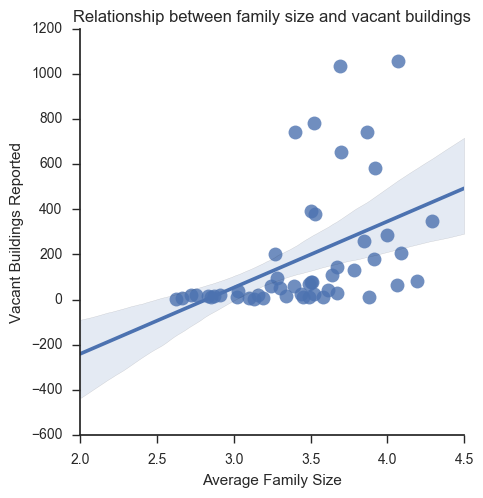

In [131]:
sns.lmplot('familysize', 'Count',
           data=count,
           fit_reg=True,
           scatter_kws={"marker": "D",
                        "s": 100})
plt.title('Relationship between family size and vacant buildings')
plt.xlabel('Average Family Size')
plt.ylabel('Vacant Buildings Reported')

The higher the number of vacant and abandoned buildings in the ZIP code, the higher likelihood of a larger average family size in the ZIP code.

## Sanitation Code Violations Demographics 

In [142]:
sani_count = sanitation.groupby('Zip Code').count()[[1]].reset_index()
sani_count['Zip Code'] = sani_count['Zip Code'].astype(int)
sani_count.columns = ['Zip Code', 'Count']

In [146]:
sani_count = sani_count.merge(vacant_demographics, on = 'Zip Code')

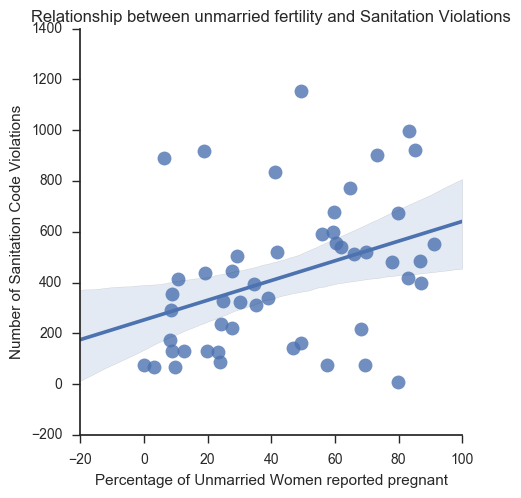

In [151]:
sns.lmplot('fertility', 'Count',
           data=sani_count,
           fit_reg=True,
           scatter_kws={"marker": "D",
                        "s": 100})
plt.title('Relationship between unmarried fertility and Sanitation Violations')
plt.xlabel('Percentage of Unmarried Women reported pregnant')
plt.ylabel('Number of Sanitation Code Violations')


There is a weak positive correlation between the number of sanitation code violations in the ZIP code and the proportion of unmarried women pregnancies in the ZIP code.

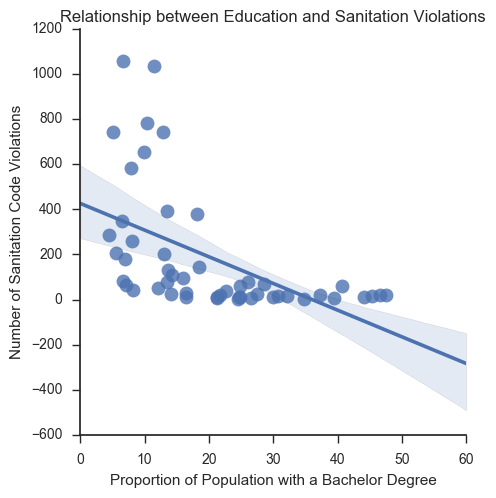

In [148]:
sns.lmplot('education', 'Count',
           data=count,
           fit_reg=True,
           scatter_kws={"marker": "D",
                        "s": 100})
plt.title('Relationship between Education and Sanitation Violations')
plt.xlabel('Proportion of Population with a Bachelor Degree')
plt.ylabel('Number of Sanitation Code Violations')

ZIP codes associated with high number of sanitation code violations tend to have a low proportion of the population with a Bachelor's degree. However, upon reaching a threshold of Bachelor degree holder (i.e. 20%), the number of sanitation code violation plateaus.

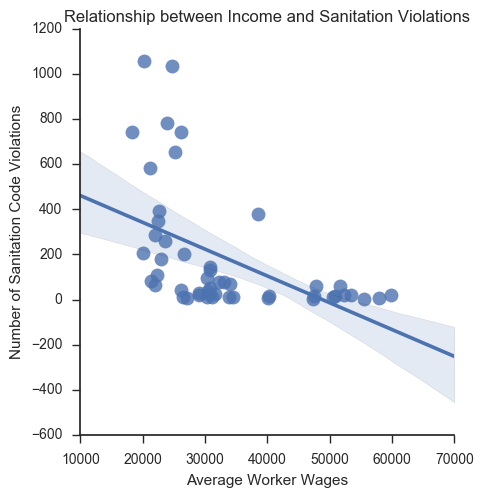

In [149]:
sns.lmplot('income', 'Count',
           data=count,
           fit_reg=True,
           scatter_kws={"marker": "D",
                        "s": 100})
plt.title('Relationship between Income and Sanitation Violations')
plt.xlabel('Average Worker Wages')
plt.ylabel('Number of Sanitation Code Violations')

ZIP codes associated with high number of sanitation code violations tend to have a low average worker wages. However, upon reaching a threshold annual wages of around 25k, the number of sanitation code violation plateaus.

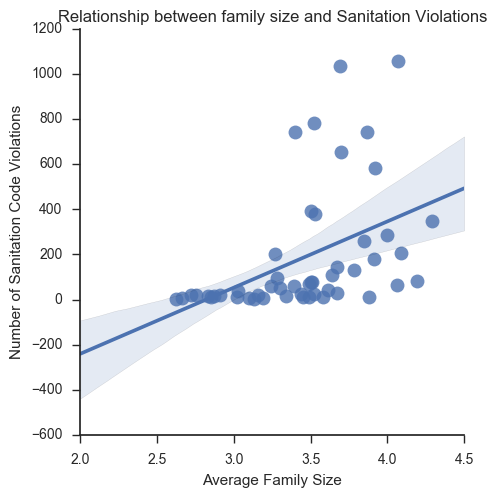

In [150]:
sns.lmplot('familysize', 'Count',
           data=count,
           fit_reg=True,
           scatter_kws={"marker": "D",
                        "s": 100})
plt.title('Relationship between family size and Sanitation Violations')
plt.xlabel('Average Family Size')
plt.ylabel('Number of Sanitation Code Violations')

There appears to be a weak positive correlation between average family size in the ZIP code and the number of sanitation code violations.

## Vacant and Abandoned Buildings vs. Sanitation Code Violations

While there is a strong positive correlation between the number of vacant and abandoned buildings and unmarried women pregnancies, there is a weak positive correlation between the number of sanitation code violations and the proportion of unmarried women pregnancies.